<a href="https://colab.research.google.com/github/wzy816/fundamentals/blob/master/023.gan_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


epoch 0
[2, 96, 72, 54, 24, 147, 93, 35, 51, 145, 95, 21, 45, 166, 125, 79]


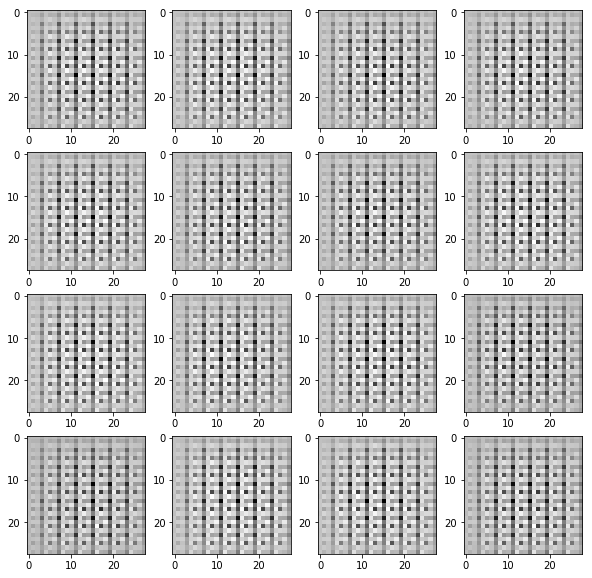

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
[83, 90, 2, 58, 89, 2, 57, 10, 129, 51, 67, 25, 11, 156, 30, 121]


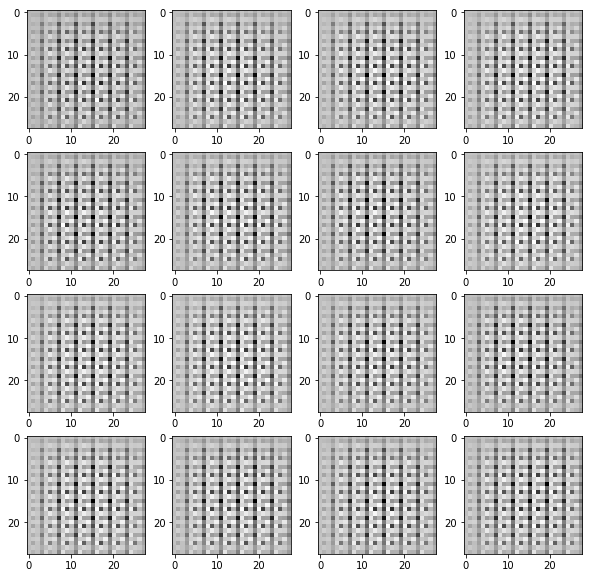

epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
[10, 140, 4, 104, 93, 131, 4, 157, 161, 36, 25, 4, 80, 75, 196, 107]


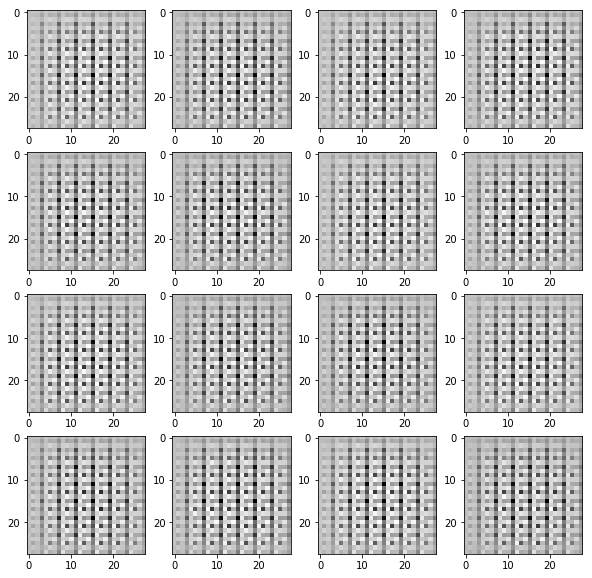

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
[123, 194, 139, 143, 10, 177, 37, 181, 109, 17, 194, 82, 177, 27, 48, 141]


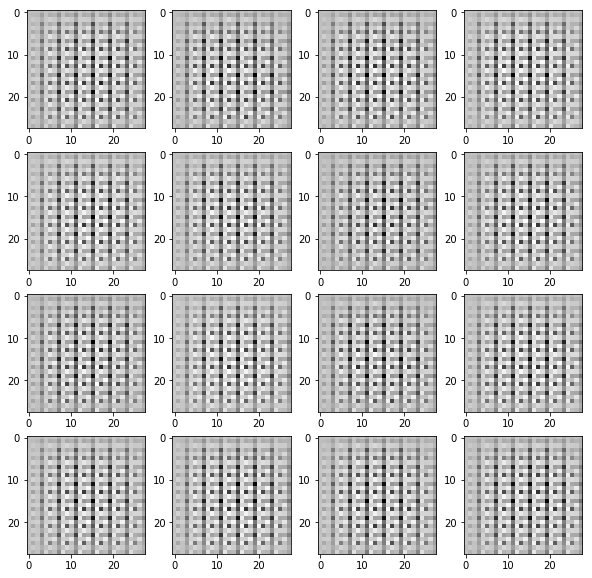

epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
[5, 156, 83, 124, 33, 82, 140, 194, 88, 135, 187, 49, 127, 62, 179, 155]


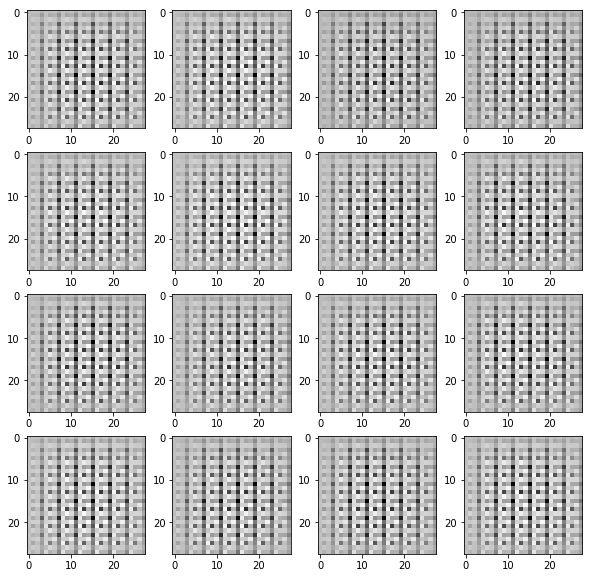

epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49


In [8]:

# coding: utf-8

# In[1]:


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.backend import *
from tensorflow.keras.optimizers import * 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
from random import shuffle,choice


# In[2]:


#flags
img_size = 28 # mnist image width/height

seed_size = 100 # size of randomly seed
kernel_size = 5

batch_size = 200
epochs = 50
learning_rate = 0.001


# In[3]:


# prepare data
mnist = tf.keras.datasets.mnist

(x_train, y_train),(_,_) = mnist.load_data()

x_train = np.array([ x for i,x in enumerate(x_train) if y_train[i] == 1])[0:6000]

x_train = (x_train.reshape(x_train.shape[0], img_size, img_size, 1).astype('float32') - 127.5) / 255.

total_batch = len(x_train) / batch_size

def next_batch():
    shuffle(x_train)
    for i in range(0, len(x_train), batch_size):
        yield x_train[i:i + batch_size]


def next_sample(batch_size):
    d = np.random.normal(0, 1.0, (batch_size, seed_size)).astype('float32')
    return d

# print(next_sample(10))


# In[4]:



generator = tf.keras.Sequential([
    Dense(7*7*batch_size, use_bias=False, input_shape=(seed_size,)),
    BatchNormalization(),LeakyReLU(),
    Reshape((7,7,batch_size)),
    Conv2DTranspose(filters=128,
                    kernel_size=(kernel_size,kernel_size),
                    strides=1,
                    padding = 'same',
                    use_bias=False),
    BatchNormalization(),LeakyReLU(),
    Conv2DTranspose(filters=64,
                    kernel_size=(kernel_size,kernel_size),
                    strides=2,
                    padding = 'same',
                    use_bias=False),
    BatchNormalization(),LeakyReLU(),
    Conv2DTranspose(filters=1,
                    kernel_size=(kernel_size,kernel_size),
                    strides=2,
                    padding = 'same',
                    use_bias=False),
])


# In[5]:


# test image generation

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    
#     z = next_sample(1)
#     image = generator(z, training=False).eval(session=sess)    
#     plt.figure()
#     plt.imshow(image[0,:,:,0], cmap='gray')


# In[6]:


# classifiy generated/train image as 1(real) or 0(fake)
discriminator = tf.keras.Sequential([
    Conv2D(filters = 64,
        kernel_size=(kernel_size,kernel_size),
        strides= 2,
        padding = 'same',
        input_shape=(28,28,1)),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(filters = 128,
        kernel_size=(kernel_size,kernel_size),
        strides= 2,
        padding = 'same'),
    LeakyReLU(),
    Dropout(0.3),  
    Flatten(),
    Dense(1)
])

def generator_loss(fake):
    return binary_crossentropy(tf.ones_like(fake), fake)

def discriminator_loss(fake, real):
    return binary_crossentropy(tf.zeros_like(fake), fake) + binary_crossentropy(tf.ones_like(real), real)


# In[7]:


# test g and d
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
    
#     samples = tf.placeholder(tf.float32,[None,100])
#     generated = generator(samples)
#     fake = discriminator(generated)
    
#     images = tf.placeholder(tf.float32,[None,28,28,1])
#     real = discriminator(images) 
    
#     g_loss = generator_loss(fake)
#     d_loss = discriminator_loss(fake,real)
    
#     z = next_sample(10)
#     f,r,g,d = sess.run([fake,real, g_loss, d_loss], feed_dict={samples:z, images:x_train[0:10]})
#     print(f,'\n')
#     print(r,'\n')
#     print(g,'\n')
#     print(d,'\n')


# In[10]:


# model
    
samples = tf.placeholder(tf.float32,[None,100])
generated = generator(samples)
fake = discriminator(generated)

images = tf.placeholder(tf.float32,[None,28,28,1])
real = discriminator(images) 

g_loss = generator_loss(fake)
d_loss = discriminator_loss(fake,real)    

g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss,var_list = generator.trainable_variables)
d_opt = tf.train.AdagradOptimizer(learning_rate).minimize(d_loss,var_list = discriminator.trainable_variables)

# train
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    test_sample = next_sample(batch_size)
    
    for epoch in range(epochs):
        print('epoch',epoch)
 
        # test
#         if epoch % 5 == 0:
#           image = sess.run([generated], feed_dict={samples:test_sample})
#           image = np.array(image) * 1000 + 127.5
#           plt.figure(figsize=(10,10))
#           for i in range(16):
#               plt.subplot(4,4,i+1)
#               plt.imshow(image[0,int(i*batch_size/16),:,:,0], cmap='gray')
#           plt.show()

        i = 0
        for x in next_batch():
            z = next_sample(batch_size)
            _,g_l = sess.run([g_opt, g_loss], feed_dict= {
                samples:z,
            })
            _,d_l = sess.run([d_opt, d_loss], feed_dict= {
                samples:z,
                images:x
            })
            i = i+1
            
        if epoch % 10 == 0:
            image = sess.run([generated], feed_dict={samples:test_sample})
            image = np.array(image) * 255 + 127.5
            plt.figure(figsize=(10,10))
            js = []
            for i in range(16):
                plt.subplot(4,4,i+1)
                j = choice(range(batch_size))
                js.append(j)
                plt.imshow(image[0,j,:,:,0], cmap='gray')
            print(js)
            plt.show()
